In [2]:
#Importing the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Importing libraries necessary to train the model
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler #For normalisation of continuous data
from sklearn.preprocessing import OneHotEncoder #For one-hot encoding of host sex, continent and presence/absence of genes
from sklearn.preprocessing import LabelEncoder #For encoding the phenotype
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression #Baseline model
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTENC

from probatus.feature_elimination import EarlyStoppingShapRFECV

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import lightgbm
from xgboost import XGBClassifier

import shap

import warnings
warnings.filterwarnings("ignore")

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Loading the dataset
data = pd.read_excel("../data/final_dataset_len_wt_avg_2025-04-01.xlsx",
                     sheet_name="Sheet1")
df = data.copy()

#Moving the Label column [Phenotype] to the end of the dataset
temp_cols = df.columns.tolist()
index = df.columns.get_loc("Phenotype")
new_cols = temp_cols[0:index] + temp_cols[index+1:] + temp_cols[index:index+1]
df = df[new_cols]

#Formatting the dataset
df['Continent'] = df['Continent'].replace('America','South America')
df['Phenotype'] = df['Phenotype'].replace({'Gastric cancer ' : 'Gastric cancer', 'Non-gastric cancer ' : 'Non-gastric cancer', 'non-gastric cancer ' : 'Non-gastric cancer' })
df['Sex'] = df['Sex'].str.title()
df.drop(df.index[(df['Sex'] == 'Not Applicable')],axis=0,inplace=True)

In [4]:
X, y = df.iloc[:,1:-1], df.iloc[:,-1] #Splitting the dataframe into Features and Labels

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=26) #Splitting the dataframe into 80% training and 20% test set through StratifiedShuffleSplit
for train_index,test_index in sss.split(X,y):
  X_train_set = X.iloc[train_index]
  y_train_set = y.iloc[train_index]
  X_test_set = X.iloc[test_index]
  y_test_set = y.iloc[test_index]

In [5]:
### Preprocessing the training set

le = LabelEncoder() # Label encoding the Labels in the training set
scaler = MinMaxScaler() # Normalising the continuous data in the training set
encoder = OneHotEncoder(sparse_output=False, handle_unknown="error") # One-hot encoding the categorical data in the training set

y_train_set_encoded = le.fit_transform(y_train_set) # Encoding the labels

numeric_cols = X_train_set.select_dtypes(include=['int64', 'float64']).columns # Selecting the numerical columns
X_train_set[numeric_cols] = scaler.fit_transform(X_train_set[numeric_cols]) # Applying MinMaxScaler only to the numeric columns

X_train_set.loc[:, "homB":"vacAs1m1"] = X_train_set.loc[:, "homB":"vacAs1m1"].astype('object') # Converting these columns to object type
categorical_columns = X_train_set.select_dtypes(include=['object']).columns.tolist() # Selecting the categorical columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown="error") # One-hot encoding the categorical columns
one_hot_encoded = encoder.fit_transform(X_train_set[categorical_columns]) 
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns),
                          index=X_train_set.index) # Creating a DataFrame from the one-hot encoded data

X_train_set_encoded = pd.concat([X_train_set, one_hot_df], axis=1) # Concatenating the one-hot encoded data with the original data

X_train_set_encoded = X_train_set_encoded.drop(categorical_columns, axis=1) # Dropping the original categorical columns
X_train_set_encoded.loc[:, "Sex_Female":"vacAs1m1_1.0"] = X_train_set_encoded.loc[:, "Sex_Female":"vacAs1m1_1.0"].astype('category') # Converting the one-hot encoded columns to category type

In [6]:
### Preprocessing the test set

y_test_set_encoded = le.transform(y_test_set)

numeric_cols_test = X_test_set.select_dtypes(include=['int64', 'float64']).columns # Selecting the numerical columns
X_test_set[numeric_cols_test] = scaler.transform(X_test_set[numeric_cols_test]) # Applying MinMaxScaler only to numeric columns

X_test_set.loc[:, "homB":"vacAs1m1"] = X_test_set.loc[:, "homB":"vacAs1m1"].astype('object') # Converting these columns to object type
categorical_columns_test = X_test_set.select_dtypes(include=['object']).columns.tolist() # Selecting the categorical columns

one_hot_encoded_test = encoder.transform(X_test_set[categorical_columns_test]) # One-hot encoding the categorical columns

one_hot_df_test = pd.DataFrame(one_hot_encoded_test, columns=encoder.get_feature_names_out(categorical_columns_test),
                          index=X_test_set.index) # Creating a DataFrame from the one-hot encoded data

X_test_set_encoded = pd.concat([X_test_set, one_hot_df_test], axis=1) # Concatenating the one-hot encoded data with the original data

X_test_set_encoded = X_test_set_encoded.drop(categorical_columns_test, axis=1) # Dropping the original categorical columns
X_test_set_encoded.loc[:, "Sex_Female":"vacAs1m1_1.0"] = X_test_set_encoded.loc[:, "Sex_Female":"vacAs1m1_1.0"].astype('category') # Converting the one-hot encoded columns to category type

In [7]:
ss = StratifiedShuffleSplit(n_splits=10, random_state=26) # Splitting the dataset into 10 folds for cross-validation

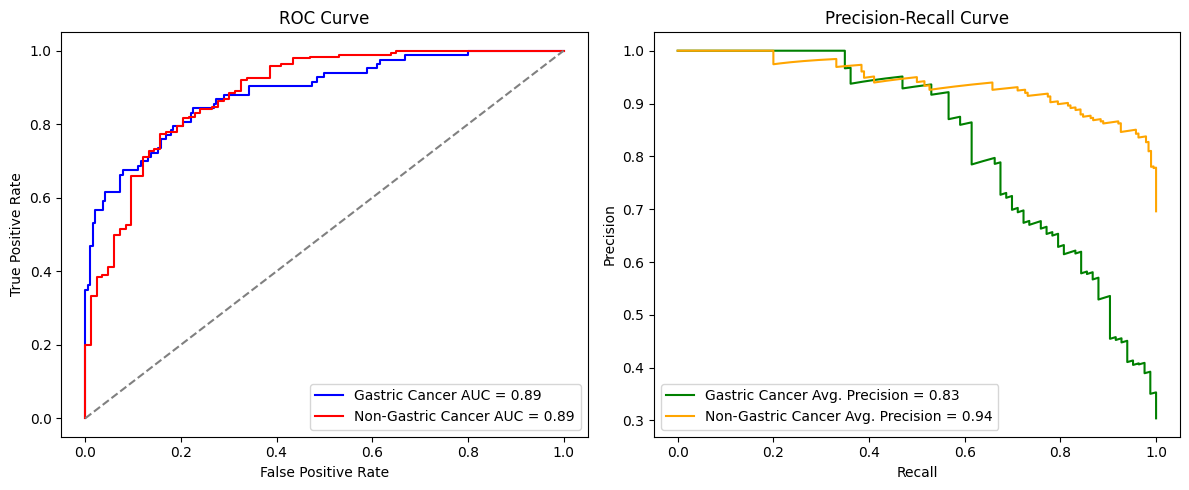

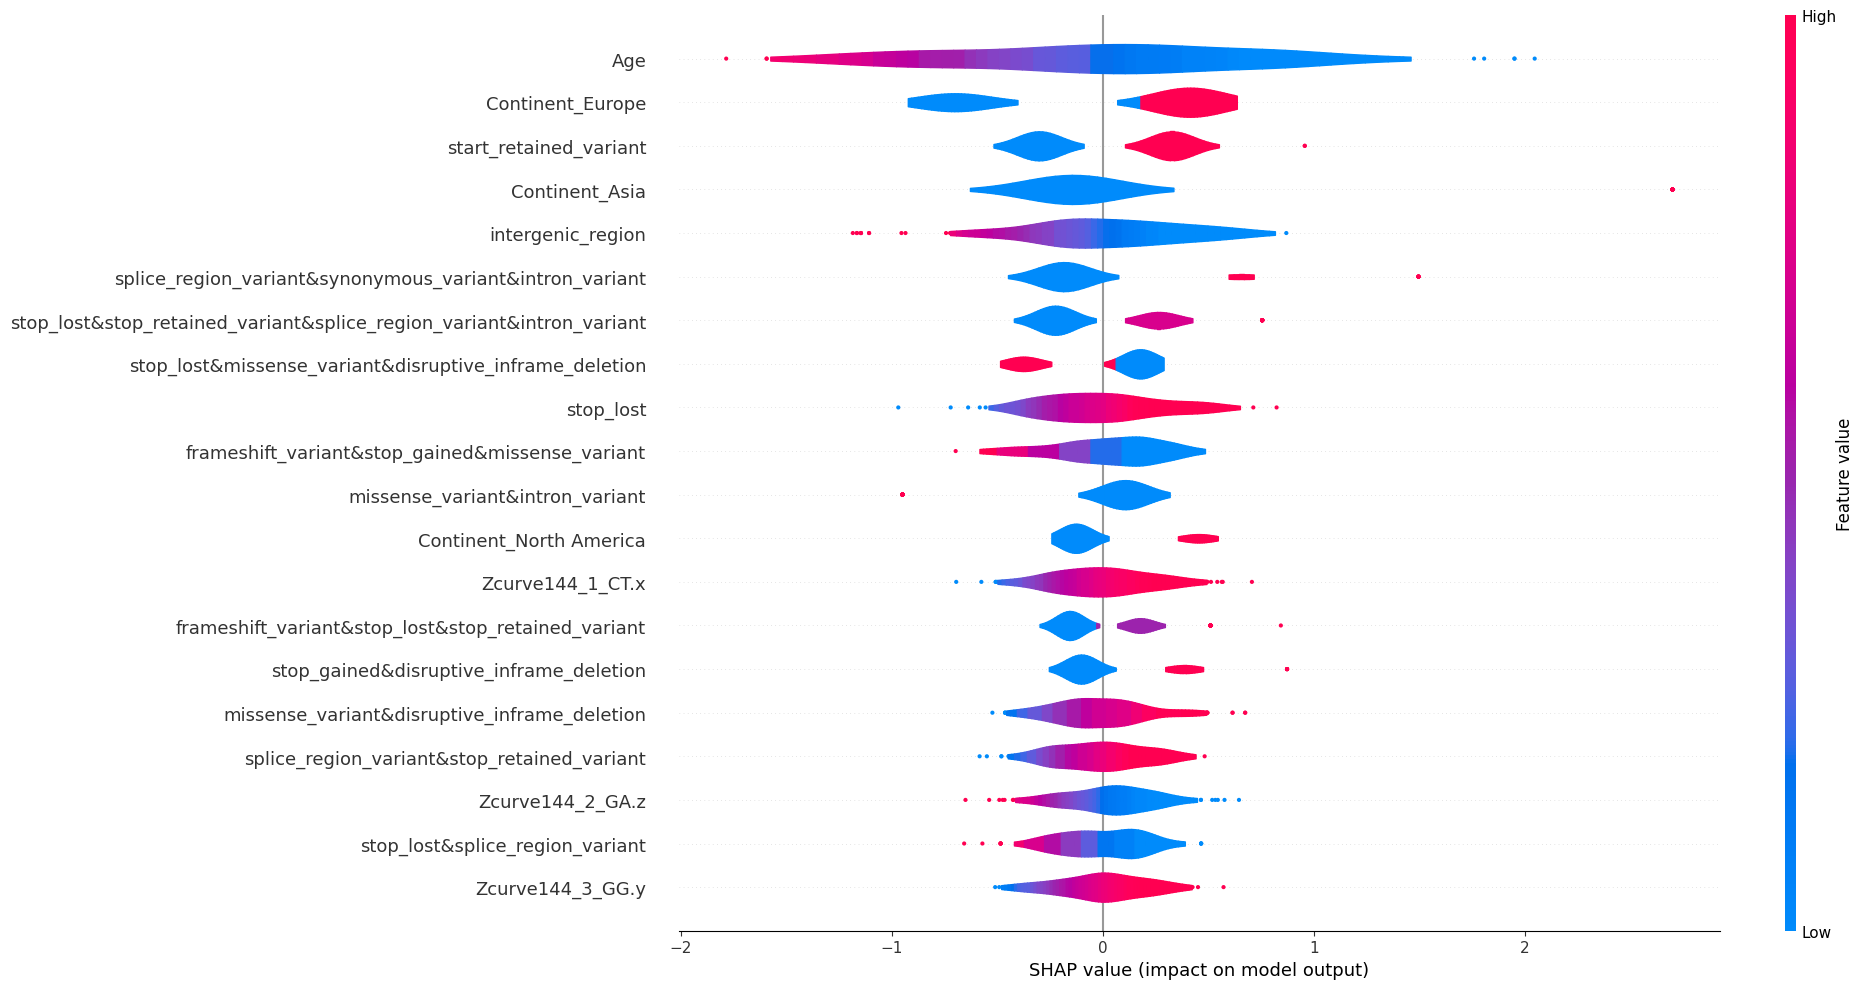

In [7]:
# Logistic Regression

categorical_features = X_train_set_encoded.select_dtypes(include=['category']).columns # Selecting the categorical features
categorical_indices = [X_train_set_encoded.columns.get_loc(col) for col in categorical_features] # Getting the indices of the categorical features for SMOTENC

lr_pipeline = make_pipeline(SMOTENC(categorical_features=categorical_indices,
                                     random_state=26),
                             LogisticRegression(random_state=26)) # Makes a pipeline with SMOTENC and Logistic Regression

lr_pipeline.fit(X_train_set_encoded, y_train_set_encoded) # Fitting the pipeline to the full training set


y_test_pred = lr_pipeline.predict(X_test_set_encoded) # Get predictions on the test set


lr_report_dict = classification_report(                 # Generate the classification report as a dictionary
    le.inverse_transform(y_test_set_encoded),
    le.inverse_transform(y_test_pred),
    output_dict=True
) 

lr_report_df = pd.DataFrame(lr_report_dict).transpose() # Convert to DataFrame

lr_report_df.to_csv("../results/2025-07-07_LR_classification_report.csv", index=True) # Save to CSV

y_proba_test_0 = lr_pipeline.predict_proba(X_test_set_encoded)[:, 0] # Gastric Cancer
y_proba_test_1 = lr_pipeline.predict_proba(X_test_set_encoded)[:, 1] # Non-Gastric Cancer
# ROC Curve
fpr_0, tpr_0, _ = roc_curve(y_test_set_encoded, y_proba_test_0, pos_label=0)
fpr_1, tpr_1, _ = roc_curve(y_test_set_encoded, y_proba_test_1, pos_label=1)

roc_auc_0 = auc(fpr_0, tpr_0)
roc_auc_1 = auc(fpr_1, tpr_1)
# PR Curve
precision_0, recall_0, _ = precision_recall_curve(y_test_set_encoded, y_proba_test_0, pos_label=0)
pr_auc_0 = average_precision_score(y_test_set_encoded, y_proba_test_0, pos_label=0, average='weighted')

precision_1, recall_1, _ = precision_recall_curve(y_test_set_encoded, y_proba_test_1, pos_label=1)
pr_auc_1 = average_precision_score(y_test_set_encoded, y_proba_test_1, pos_label=1, average='weighted')
# Plotting
plt.figure(figsize=(12, 5))

# ROC Plot
plt.subplot(1, 2, 1)
plt.plot(fpr_0, tpr_0, color='blue', label=f"Gastric Cancer AUC = {roc_auc_0:.2f}")
plt.plot(fpr_1, tpr_1, color='red', label=f"Non-Gastric Cancer AUC = {roc_auc_1:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# PR Plot
plt.subplot(1, 2, 2)
plt.plot(recall_0, precision_0, color='green', label=f"Gastric Cancer Avg. Precision = {pr_auc_0:.2f}")
plt.plot(recall_1, precision_1, color='orange', label=f"Non-Gastric Cancer Avg. Precision = {pr_auc_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.savefig("../results/2025-07-07_LR_roc_pr_curve.png", dpi=1200)
plt.show()

# Convert categorical columns to numeric for SHAP
X_test_set_encoded = X_test_set_encoded.copy()
for col in X_test_set_encoded.select_dtypes(include=['category']).columns:
    X_test_set_encoded[col] = X_test_set_encoded[col].cat.codes
# X_test_set_encoded.dtypes.to_dict()

# Create SHAP explainer and compute values
explainer_LR = shap.Explainer(lr_pipeline.named_steps['logisticregression'], X_test_set_encoded)
shap_values_LR = explainer_LR.shap_values(X_test_set_encoded)

# Create the summary plot and then save it
shap.summary_plot(shap_values_LR, X_test_set_encoded,
                  feature_names=X_test_set_encoded.columns.tolist(), plot_size=(20,10), plot_type="violin", show=False)

plt.tight_layout()  # Optional: improves layout
plt.savefig("../results/2025-07-07_LR_shap_summary_plot.png", dpi=1200, bbox_inches='tight')

In [8]:
# Bayesian Optimization and Feature Elimination

model_bayes = lightgbm.LGBMClassifier(max_depth=5, class_weight="balanced") # Model for Bayesian optimization

param_grid_bayes = {                 # Hyperparameter grid for Bayesian optimization
    "n_estimators": [5, 7, 10],
    "num_leaves": [3, 5, 7, 10],
}

search_bayes = BayesSearchCV(       # Bayesian optimization using scikit-optimize
    estimator=model_bayes,
    search_spaces=param_grid_bayes,
    random_state=26
)

# Create the EarlyStoppingShapRFECV object with early stopping parameters
shap_elimination_bayes = EarlyStoppingShapRFECV(
    model=search_bayes,           # hyperparameter tuning wrapper
    step=0.2,                     # proportion or number of features to remove per iteration
    cv=ss,                        # cross-validation splitter
    scoring='recall',             # evaluation metric used for CV
    eval_metric='recall',         # early stopping evaluation metric
    early_stopping_rounds=30,     # stop if no improvement is seen for 30 rounds
    n_jobs=-1,
    verbose=2,
    random_state=26
)

# Run feature selection
report_bayes = shap_elimination_bayes.fit_compute(X_train_set_encoded, y_train_set_encoded)

best_features_bayes = shap_elimination_bayes.get_reduced_features_set(num_features="best") # Get the best features

final_features_set_bayes = shap_elimination_bayes.get_reduced_features_set(num_features=len(best_features_bayes)) # Get the final features set

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.003218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94118
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 498
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.835239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94087
[LightGBM] [Info] Numb

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.549609
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.549609
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.500783
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.500783
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.494095
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.494095
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.906980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94182
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 499
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.973667 seconds.
You can set `force_row_wise=true` to 

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.473565
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.473565
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.521725
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.521725
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94187
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 498
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_logloss: 0.658176
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.160457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94184
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 498
[LightGBM] [Warning] Found whitespace in featu

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[7]	valid_0's binary_logloss: 0.535728
[8]	valid_0's binary_logloss: 0.518393
[9]	valid_0's binary_logloss: 0.504964
[10]	valid_0's binary_logloss: 0.496536
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.496536
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-07-11 13:55:33.802 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 1, Current number of features: 548, Current performance: Train 0.819236417033774 +/- 0.01740506278866822, CV Validation 0.7473684210526315 +/- 0.04588314677411237. 
Features left: ['Age', 'conservative_inframe_deletion', 'conservative_inframe_deletion&initiator_codon_variant', 'conservative_inframe_deletion&splice_region_variant', 'conservative_inframe_deletion&splice_region_variant&synonymous_variant', 'conservative_inframe_deletion&stop_retained_variant', 'conservative_inframe_deletion&synonymous_variant', 'conservative_inframe_insertion', 'conservative_inframe_insertion&splice_region_variant', 'conservative_inframe_insertion&splice_region_variant&stop_retained_

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.436481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69195
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 391
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.498562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

Exception ignored in: <function ResourceTracker.__del__ at 0x7226de3b44a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 606, number of negative: 266


Exception ignored in: <function ResourceTracker.__del__ at 0x7f02d72244a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.003062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69198
[LightGBM] [Info] Number of data points in the train set: 872, number of used features: 387
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Exception ignored in: <function ResourceTracker.__del__ at 0x7fa0f913c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7c13880ec4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.330921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69195
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 391
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.677066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.529248
[7]	valid_0's binary_logloss: 0.586446
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[8]	valid_0's binary_logloss: 0.523863
[9]	valid_0's binary_logloss: 0.519897
[8]	valid_0's binary_logloss: 0.579033
[9]	valid_0's binary_logloss: 0.509242
[10]	valid_0's binary_logloss: 0.510281
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.510281
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[9]	valid_0's binary_logloss: 0.567309
[10]	valid_0's binary_logloss: 0.49759
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.49759
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.558454
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.558454
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.941114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69220
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 392
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[1]	valid_0's binary_logloss: 0.656631
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.627489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.284559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[8]	valid_0's binary_logloss: 0.549096
[10]	valid_0's binary_logloss: 0.494529
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.494529
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.469842
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.469842
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[9]	valid_0's binary_logloss: 0.539254
[10]	valid_0's binary_logloss: 0.524988
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.524988
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.870918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69219
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 391
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.712707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69223
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 391
[1]	valid_0's binary_logloss: 0.659987
Training until validation scores don't impr

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.514814
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.514814
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-07-11 14:17:22.558 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 2, Current number of features: 439, Current performance: Train 0.7897209985315712 +/- 0.011558689371015823, CV Validation 0.7552631578947369 +/- 0.05431517747513236. 
Features left: ['Age', 'conservative_inframe_deletion&initiator_codon_variant', 'conservative_inframe_deletion&splice_region_variant', 'conservative_inframe_deletion&splice_region_variant&synonymous_variant', 'conservative_inframe_deletion&stop_retained_variant', 'conservative_inframe_deletion&synonymous_variant', 'conservative_inframe_insertion', 'conservative_inframe_insertion&splice_region_variant', 'conservative_inframe_insertion&splice_region_variant&stop_retained_variant', 'conservative_inframe

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.867468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53564
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 313
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.970484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

Exception ignored in: <function ResourceTracker.__del__ at 0x799aeb2384a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.405092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53570
[LightGBM] [Info] Number of data points in the train set: 872, number of used features: 310
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Exception ignored in: <function ResourceTracker.__del__ at 0x7738d61e84a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.726218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53564
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 313
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266


Exception ignored in: <function ResourceTracker.__del__ at 0x77570fe544a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7b7fd6c5c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.723689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53562
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 313
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.523083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53571
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 312
[LightGBM] [I

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[9]	valid_0's binary_logloss: 0.495232
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[8]	valid_0's binary_logloss: 0.523822
[10]	valid_0's binary_logloss: 0.477296
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.477296
Evaluated only: binary_logloss
[9]	valid_0's binary_logloss: 0.505399


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.910155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53587
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 312
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.098460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53588
[LightGBM] [Info] Number of

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[1]	valid_0's binary_logloss: 0.652673
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[1]	valid_0's binary_logloss: 0.655925
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.839571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53584
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 313
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[2]	valid_0's binary_logloss: 0.619882
[2]	valid_0's binary_logloss: 0.619798
[1]	valid_

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.49228
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.49228
Evaluated only: binary_logloss
[9]	valid_0's binary_logloss: 0.485638


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[7]	valid_0's binary_logloss: 0.548691
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.474459
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.474459
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.537057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.537250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53586
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 313
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[9]	valid_0's binary_logloss: 0.526525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.542640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53590
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 313
[Lig

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.629939
[2]	valid_0's binary_logloss: 0.624584
[3]	valid_0's binary_logloss: 0.599396
[3]	valid_0's binary_logloss: 0.609511
[4]	valid_0's binary_logloss: 0.578341
[4]	valid_0's binary_logloss: 0.583809
[5]	valid_0's binary_logloss: 0.559702
[5]	valid_0's binary_logloss: 0.569702
[6]	valid_0's binary_logloss: 0.550376
[6]	valid_0's binary_logloss: 0.553206
[7]	valid_0's binary_logloss: 0.536109
[7]	valid_0's binary_logloss: 0.541587
[8]	valid_0's binary_logloss: 0.518926
[8]	valid_0's binary_logloss: 0.528374
[9]	valid_0's binary_logloss: 0.510295
[9]	valid_0's binary_logloss: 0.513772
[10]	valid_0's binary_logloss: 0.498774
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.498774
Evaluated only: binary_logloss
[10]	valid_0's binary_logloss: 0.511027
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.511027
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-07-11 14:42:49.173 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 3, Current number of features: 352, Current performance: Train 0.8132158590308369 +/- 0.015000990060642741, CV Validation 0.7605263157894737 +/- 0.0572935290975717. 
Features left: ['Age', 'conservative_inframe_deletion&splice_region_variant', 'conservative_inframe_deletion&splice_region_variant&synonymous_variant', 'conservative_inframe_deletion&stop_retained_variant', 'conservative_inframe_deletion&synonymous_variant', 'conservative_inframe_

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.560968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41041
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 254
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.490908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41039
[LightGBM] [Info] Numb

Exception ignored in: <function ResourceTracker.__del__ at 0x754c341644a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.570202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41039
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 254
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Exception ignored in: <function ResourceTracker.__del__ at 0x7c5e3077c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.592313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41049
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 253
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.503445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tr

Exception ignored in: <function ResourceTracker.__del__ at 0x74904a9504a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.606348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41047
[LightGBM] [Info] Number of data points in the train set: 872, number of used features: 251
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Exception ignored in: <function ResourceTracker.__del__ at 0x762c5833c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.453612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41041
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 254
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.556949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.477296
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.477296
Evaluated only: binary_logloss
[10]	valid_0's binary_logloss: 0.494408
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.494408
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.915875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41065
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 255
[LightGBM] [Info] Auto-choosing row-wise multi-threading, t

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.49228
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.49228
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[9]	valid_0's binary_logloss: 0.526525
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[9]	valid_0's binary_logloss: 0.49305
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.4841
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.4841
Evaluated only: binary_logloss
[10]	valid_0's binary_logloss: 0.519206
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.519206
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.847874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41063
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 254
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.844879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41067
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 254
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[L

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.518926
[9]	valid_0's binary_logloss: 0.510295
[10]	valid_0's binary_logloss: 0.498774
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.498774
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-07-11 14:58:37.062 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 4, Current number of features: 282, Current performance: Train 0.8132158590308369 +/- 0.015000990060642741, CV Validation 0.7605263157894737 +/- 0.0572935290975717. 
Features left: ['Age', 'conservative_inframe_deletion&splice_region_variant&synonymous_variant', 'conservative_inframe_deletion&stop_retained_variant', 'conservative_inframe_deletion&synonymous_variant', 'conservative_inframe_insertion', 'conservative_inframe_insertion&splice_region_variant', 'conservative_inframe_insertion&splice_region_variant&stop_retained_variant', 'conservative_inframe_insertion&splice_region_variant&synonymous_variant', 'conservative_inframe_insertion&stop_retained_variant', 'co

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32547
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.264229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

Exception ignored in: <function ResourceTracker.__del__ at 0x7dac554304a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x79cdeadb84a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.278938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32547
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Exception ignored in: <function ResourceTracker.__del__ at 0x7af203bd84a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7dd9c144c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.340570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32545
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.254970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32554
[LightGBM] [Info] Numb

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[9]	valid_0's binary_logloss: 0.499314
[10]	valid_0's binary_logloss: 0.477296
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.477296
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.494408
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.494408
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.778223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32567
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 201
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.719980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32569
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 200
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initsc

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[9]	valid_0's binary_logloss: 0.498555
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[9]	valid_0's binary_logloss: 0.526525
[10]	valid_0's binary_logloss: 0.474459
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.474459
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.49228
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.49228
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.519206
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.519206
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.280907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32568
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 201
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.792397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32571
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 201
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_logloss: 0.658176
Training until validation scores don't improve for 30 rounds
[1]	valid_0's binary_logloss: 0.655334
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.629939
[2]	valid_0's binary_logloss: 0.624584
[3]	valid_0's binary_logloss: 0.609511
[3]	valid_0's binary_logloss: 0.599396
[4]	valid_0's binary_logloss: 0.583809
[4]	valid_0's binary_logloss: 0.578341
[

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.518926
[9]	valid_0's binary_logloss: 0.510295
[10]	valid_0's binary_logloss: 0.498774
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.498774
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-07-11 15:12:27.168 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 5, Current number of features: 226, Current performance: Train 0.8132158590308369 +/- 0.015000990060642741, CV Validation 0.7605263157894737 +/- 0.0572935290975717. 
Features left: ['Age', 'conservative_inframe_deletion&stop_retained_variant', 'conservative_inframe_deletion&synonymous_variant', 'conservative_inframe_insertion', 'conservative_inframe_insertion&splice_region_variant', 'conservative_inframe_insertion&splice_region_variant&stop_retained_variant', 'conservative_inframe_insertion&splice_region_variant&synonymous_variant', 'conservative_inframe_insertion&stop_retained_variant', 'conservative_inframe_insertion&stop_retained_variant&splice_region_variant',

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27100
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27096
[LightGBM] [Info] Numb

Exception ignored in: <function ResourceTracker.__del__ at 0x757bfa0ec4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x79802fba44a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.226654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27109
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.244843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tr

Exception ignored in: <function ResourceTracker.__del__ at 0x7a5249e484a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 606, number of negative: 266


Exception ignored in: <function ResourceTracker.__del__ at 0x794bf11b44a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.434404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27110
[LightGBM] [Info] Number of data points in the train set: 872, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.254650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27100
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 164
[LightGBM] [Inf

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.494408
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.494408
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[9]	valid_0's binary_logloss: 0.505399
[9]	valid_0's binary_logloss: 0.556778
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.341723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27118
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 164
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[10]	valid_0's binary_logloss: 0.553938
Did not meet early stop

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_logloss: 0.655925
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.619798
[3]	valid_0's binary_logloss: 0.589782
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[1]	valid_0's binary_logloss: 0.652673
Training until validation scores don't improve for 30 rounds
[4]	valid_0's binary_logloss: 0.569592
[5]	valid_0's binary_logloss: 0.54864
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.429955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27118
[LightGBM] [Info] Numb

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[7]	valid_0's binary_logloss: 0.518779
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[8]	valid_0's binary_logloss: 0.509022
[9]	valid_0's binary_logloss: 0.498555
[5]	valid_0's binary_logloss: 0.553838
[4]	valid_0's binary_logloss: 0.593189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.495901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27119
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 164
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[10]	valid_0's binary_logloss: 0.49228
Did not meet early stopping. Best iteration is:
[10]	v

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[6]	valid_0's binary_logloss: 0.531595
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[5]	valid_0's binary_logloss: 0.572701
[1]	valid_0's binary_logloss: 0.658176
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.394534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27122
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 164
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[7]	valid_0's binary_logloss: 0.51928
[6]	valid_0's binary_logloss: 0.56011
[1]	valid_0's binary_logloss: 0.65

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[5]	valid_0's binary_logloss: 0.569702
[7]	valid_0's binary_logloss: 0.536109
[10]	valid_0's binary_logloss: 0.519206
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.519206
Evaluated only: binary_logloss
[6]	valid_0's binary_logloss: 0.553206


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.518926
[7]	valid_0's binary_logloss: 0.541587
[9]	valid_0's binary_logloss: 0.510295
[8]	valid_0's binary_logloss: 0.528374
[10]	valid_0's binary_logloss: 0.498774
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.498774
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[9]	valid_0's binary_logloss: 0.513772
[10]	valid_0's binary_logloss: 0.511027
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.511027
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-07-11 15:25:18.164 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 6, Current number of features: 181, Current performance: Train 0.8132158590308369 +/- 0.015000990060642741, CV Validation 0.7605263157894737 +/- 0.0572935290975717. 
Features left: ['Age', 'conservative_inframe_deletion&synonymous_variant', 'conservative_inframe_insertion', 'conservative_inframe_insertion&splice_region_variant', 'conservative_inframe_insertion&splice_region_variant&stop_retained_variant', 'conservative_inframe_insertion&splice_region_variant&synonymous_variant', 'conservative_inframe_insertion&stop_retained_variant', 'disruptive_inframe_deletion', 'disruptive_inframe_deletion&synonymous_variant', 'frameshift_variant', 'frameshift_variant&splice_re

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23663
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

Exception ignored in: <function ResourceTracker.__del__ at 0x7c62eaa4c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23658
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23670
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 141
[LightGBM] [I

Exception ignored in: <function ResourceTracker.__del__ at 0x76de6390c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23671
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 606, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tr

Exception ignored in: <function ResourceTracker.__del__ at 0x71359a13c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f4a7e9c84a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23663
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[9]	valid_0's binary_logloss: 0.499314
[10]	valid_0's binary_logloss: 0.553938
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.553938
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[8]	valid_0's binary_logloss: 0.505231


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.374090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23678
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 141
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[10]	valid_0's binary_logloss: 0.494408
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.494408
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.278869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23683
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 141
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[9]	valid_0's binary_logloss: 0.495232
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[1]	valid_0's binary_logloss: 0.655925
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.300218 seconds.
You can set `force_row_wise=true` to remove t

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.619798
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[1]	valid_0's binary_logloss: 0.655579
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.619882
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.387576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23678
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 141
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[3]	valid_0's binary_logloss: 0.589782
[4]	valid_0's binary_logloss: 0.569592
[3]	valid_0's binary_logloss: 0.

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[9]	valid_0's binary_logloss: 0.498555
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.318986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23679
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 141
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[10]	valid_0's binary_logloss: 0.4841
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.4841
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.537057
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.49228
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.49228
Evaluated only: binary_logloss
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.305863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23681
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 141
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_logloss: 0.658176
Training until validation scores don't improve for 30

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[9]	valid_0's binary_logloss: 0.526525
[1]	valid_0's binary_logloss: 0.655334
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.629939
[10]	valid_0's binary_logloss: 0.519206
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.519206
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.624584
[3]	valid_0's binary_logloss: 0.609511
[3]	valid_0's binary_logloss: 0.599396
[4]	valid_0's binary_logloss: 0.578341
[4]	valid_0's binary_logloss: 0.583809
[5]	valid_0's binary_logloss: 0.559702
[5]	valid_0's binary_logloss: 0.569702
[6]	valid_0's binary_logloss: 0.550376
[6]	valid_0's binary_logloss: 0.553206
[7]	valid_0's binary_logloss: 0.536109
[7]	valid_0's binary_logloss: 0.541587
[8]	valid_0's binary_logloss: 0.518926
[8]	valid_0's binary_logloss: 0.528374
[9]	valid_0's binary_logloss: 0.510295
[9]	valid_0's binary_logloss: 0.513772
[10]	valid_0's binary_logloss: 0.511027
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.511027
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.498774
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.498774
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-07-11 15:36:01.621 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 7, Current number of features: 145, Current performance: Train 0.8132158590308369 +/- 0.015000990060642741, CV Validation 0.7605263157894737 +/- 0.0572935290975717. 
Features left: ['Age', 'conservative_inframe_insertion', 'disruptive_inframe_deletion', 'disruptive_inframe_deletion&synonymous_variant', 'frameshift_variant', 'frameshift_variant&splice_region_variant', 'frameshift_variant&start_lost', 'frameshift_variant&stop_gained', 'frameshift_variant&stop_gained&missense_variant', 'frameshift_variant&stop_lost', 'frameshift_variant&stop_lost&missense_variant&splice_region_variant', 'frameshift_variant&stop_lost&splice_region_variant', 'frameshift_variant&stop_lo

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21817
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21812
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Nu

Exception ignored in: <function ResourceTracker.__del__ at 0x78fba88444a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x76e4a2be84a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21817
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21812
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM]

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[9]	valid_0's binary_logloss: 0.499314
[7]	valid_0's binary_logloss: 0.535869
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21832
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[9]	valid_0's binary_logloss: 0.495232
[10]	valid_0's binary_logloss: 0.494408
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.494408
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.523822
[1]	valid_0's binary_logloss: 0.655925
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.477296
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.477296
Evaluated only: binary_logloss
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21836
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[9]	valid_0's binary_logloss: 0.505399
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[2]	valid_0's binary_logloss: 0.619798
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21832
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_logloss: 0.652673
Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.491469
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.491469
Evaluated only: binary_logloss
[1]	valid_0's binary_logloss: 0.655579
Training until validation scores don't improve for 30 rounds
[3]	valid_0's binary_logloss: 0.589782


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.619882
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21831
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[4]	valid_0's binary_logloss: 0.569592
[2]	valid_0's binary_logloss: 0.618835
[3]	valid_0's binary_logloss: 0.597534
[1]	valid_0's binary_logloss: 0.665808
Training until validation scores don't improve for 30 rounds
[3]	valid_0's binary_logloss: 0.595854
[5]	valid_0's binary_logloss: 0.54864
[4]	valid_0's binary_logloss: 0.575862
[2]	valid_0's binary_logloss: 0.634004
[6]	valid_0's binary_logloss: 0.533987
[4]	valid_0's binary_logloss: 0.571514
[5]	valid_0's binary_lo

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[6]	valid_0's binary_logloss: 0.56011
[8]	valid_0's binary_logloss: 0.502914
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21832
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[9]	valid_0's binary_logloss: 0.498555
[7]	valid_0's binary_logloss: 0.548691
[9]	valid_0's binary_logloss: 0.485638
[1]	valid_0's binary_logloss: 0.658176
Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.49228
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.49228
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.537057
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.474459
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.474459
Evaluated only: binary_logloss
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21834
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.629939
[9]	valid_0's binary_logloss: 0.526525
[1]	valid_0's binary_logloss: 0.655334
Training until validation scores don't improve for 30 rounds
[3]	valid_0's binary_logloss: 0.609511
[10]	valid_0's binary_logloss: 0.519206
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.519206
Evaluated only: binary_logloss
[2]	valid_0's binary_logloss: 0.624584


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[4]	valid_0's binary_logloss: 0.583809
[3]	valid_0's binary_logloss: 0.599396
[5]	valid_0's binary_logloss: 0.569702
[4]	valid_0's binary_logloss: 0.578341
[6]	valid_0's binary_logloss: 0.553206
[5]	valid_0's binary_logloss: 0.559702
[7]	valid_0's binary_logloss: 0.541587
[6]	valid_0's binary_logloss: 0.550376
[8]	valid_0's binary_logloss: 0.528374
[7]	valid_0's binary_logloss: 0.536109
[9]	valid_0's binary_logloss: 0.513772
[8]	valid_0's binary_logloss: 0.518926
[10]	valid_0's binary_logloss: 0.511027
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.511027
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[9]	valid_0's binary_logloss: 0.510295
[10]	valid_0's binary_logloss: 0.498774
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.498774
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-07-11 15:45:24.804 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 8, Current number of features: 116, Current performance: Train 0.8132158590308369 +/- 0.015000990060642741, CV Validation 0.7605263157894737 +/- 0.0572935290975717. 
Features left: ['Age', 'conservative_inframe_insertion', 'disruptive_inframe_deletion', 'disruptive_inframe_deletion&synonymous_variant', 'frameshift_variant', 'frameshift_variant&start_lost', 'frameshift_variant&stop_gained', 'frameshift_variant&stop_lost', 'frameshift_variant&stop_lost&missense_variant&splice_region_variant', 'frameshift_variant&stop_lost&splice_region_variant', 'frameshift_variant&stop_lost&splice_region_variant&stop_retained_variant', 'frameshift_variant&stop_lost&stop_retained_va

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17950
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17944
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Numb

Exception ignored in: <function ResourceTracker.__del__ at 0x71ebe15b44a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x78c7e377c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17950
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Exception ignored in: <function ResourceTracker.__del__ at 0x7a39ee93c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17944
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17956
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [I

Exception ignored in: <function ResourceTracker.__del__ at 0x75388c95c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17956
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 606, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17956
[LightGBM] [Info] Number of data points in the train set: 872, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Inf

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.504398
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17964
[9]	valid_0's binary_logloss: 0.505399
[9]	valid_0's binary_logloss: 0.499314
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[9]	valid_0's binary_logloss: 0.494283
[10]	valid_0's binary_logloss: 0.491469
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.491469
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.493172
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.493172
Evaluated only: binary_logloss
[1]	valid_0's binary_logloss: 0.655925
Training until validation scores don't improve for 30 rounds


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.47641
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.47641
Evaluated only: binary_logloss
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17968
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 93
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17964
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[2]	valid_0's binary_logloss: 0.619798
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17963
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17964
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[8]	valid_0's binary_logloss: 0.509022
[10]	valid_0's binary_logloss: 0.481043
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.481043
Evaluated only: binary_logloss
[9]	valid_0's binary_logloss: 0.527515


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[1]	valid_0's binary_logloss: 0.658176
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17966
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[9]	valid_0's binary_logloss: 0.498555
[10]	valid_0's binary_logloss: 0.520204
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.520204
Evaluated only: binary_logloss
[2]	valid_0's binary_logloss: 0.629939
[1]	valid_0's binary_logloss: 0.655334
Training until validation scores don't improve for 30 rounds


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.49232
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.49232
Evaluated only: binary_logloss
[3]	valid_0's binary_logloss: 0.608496


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.624584
[4]	valid_0's binary_logloss: 0.582845
[3]	valid_0's binary_logloss: 0.599396
[5]	valid_0's binary_logloss: 0.568769
[4]	valid_0's binary_logloss: 0.576162
[6]	valid_0's binary_logloss: 0.548925
[7]	valid_0's binary_logloss: 0.538164
[8]	valid_0's binary_logloss: 0.526635
[9]	valid_0's binary_logloss: 0.512621
[5]	valid_0's binary_logloss: 0.560706
[10]	valid_0's binary_logloss: 0.502352
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.502352
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-07-11 15:53:26.909 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 9, Current number of features: 93, Current performance: Train 0.8182085168869311 +/- 0.010806678116284324, CV Validation 0.7631578947368423 +/- 0.052959504730258185. 
Features left: ['Age', 'conservative_inframe_insertion', 'disruptive_inframe_deletion', 'disruptive_inframe_deletion&synonymous_variant', 'frameshift_variant', 'frameshift_variant&start_lost', 'frameshift_variant&stop_gained', 'frameshift_variant&stop_lost', 'frameshift_variant&s

[6]	valid_0's binary_logloss: 0.551567
[7]	valid_0's binary_logloss: 0.537385
[8]	valid_0's binary_logloss: 0.51944
[9]	valid_0's binary_logloss: 0.510949
[10]	valid_0's binary_logloss: 0.499656
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.499656
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14318
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007091 seconds.
You can set `force_row_wis

Exception ignored in: <function ResourceTracker.__del__ at 0x7ae58a3404a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7a2ac42444a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14318
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14314
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Numb

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.510577
[8]	valid_0's binary_logloss: 0.558506
[9]	valid_0's binary_logloss: 0.552711
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14332
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[10]	valid_0's binary_logloss: 0.482606
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.482606
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[9]	valid_0's binary_logloss: 0.500573
[10]	valid_0's binary_logloss: 0.542061
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.542061
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14336
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 75
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14333
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_loglo

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[1]	valid_0's binary_logloss: 0.652673
Training until validation scores don't improve for 30 rounds
[1]	valid_0's binary_logloss: 0.655579
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14332
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[2]	valid_0's binary_logloss: 0.619798
[2]	valid_0's binary_logloss: 0.619882
[2]	valid_0's binary_logloss: 0.618835
[1]	valid_0's binary_logloss: 0.665808
Training until validation scores don't improve for 30 rounds
[3]	valid_0's binary_logloss: 0.589782
[3]	valid_0's binary_logloss: 0.597534
[3]	valid_0's bina

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.471056
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.471056
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14332
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[9]	valid_0's binary_logloss: 0.527307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14334
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[10]	valid_0's binary_logloss: 0.482358
Did not meet e

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.520309
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.520309
Evaluated only: binary_logloss
[1]	valid_0's binary_logloss: 0.658176
Training until validation scores don't improve for 30 rounds
[1]	valid_0's binary_logloss: 0.654744
Training until validation scores don't improve for 30 rounds


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.629939
[2]	valid_0's binary_logloss: 0.62474
[3]	valid_0's binary_logloss: 0.608496
[3]	valid_0's binary_logloss: 0.601265
[4]	valid_0's binary_logloss: 0.583218
[4]	valid_0's binary_logloss: 0.57899
[5]	valid_0's binary_logloss: 0.569236
[5]	valid_0's binary_logloss: 0.5624
[6]	valid_0's binary_logloss: 0.54944
[6]	valid_0's binary_logloss: 0.542161
[7]	valid_0's binary_logloss: 0.536641
[7]	valid_0's binary_logloss: 0.525974
[8]	valid_0's binary_logloss: 0.527879
[8]	valid_0's binary_logloss: 0.513233
[9]	valid_0's binary_logloss: 0.513957
[9]	valid_0's binary_logloss: 0.504781
[10]	valid_0's binary_logloss: 0.506406
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.506406
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.491217
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.491217
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-07-11 16:01:57.671 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 10, Current number of features: 75, Current performance: Train 0.8157121879588839 +/- 0.0163022050742838, CV Validation 0.7513157894736842 +/- 0.04612775827094238. 
Features left: ['Age', 'conservative_inframe_insertion', 'disruptive_inframe_deletion', 'disruptive_inframe_deletion&synonymous_variant', 'frameshift_variant', 'frameshift_variant&start_lost', 'frameshift_variant&stop_lost', 'frameshift_variant&stop_lost&splice_region_variant', 'intragenic_variant', 'missense_variant', 'missense_variant&disruptive_inframe_deletion', 'splice_region_variant&stop_retained_variant', 'start_lost&missense_variant', 'stop_gained', 'stop_gained&missense_variant&conservative_in

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11650
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11650
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Numb

Exception ignored in: <function ResourceTracker.__del__ at 0x73c37a4ec4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x73175104c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11650
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Exception ignored in: <function ResourceTracker.__del__ at 0x78835f0504a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x75173f3b44a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11650
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11658
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11663
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[3]	valid_0's binary_logloss: 0.59382
[1]	valid_0's binary_logloss: 0.655925
Training until validation scores don't improve for 30 rounds
[4]	valid_0's binary_logloss: 0.575257
[2]	valid_0's binary_logloss: 0.618305
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[5]	valid_0's binary_logloss: 0.558213
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.626886
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[6]	valid_0's binary_logloss: 0.531865
[3]	valid_0's binary_logloss: 0.609667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11667
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[3]	valid_0's binary_logloss: 0.598209
[4]	valid_0's binary_logloss: 0.587497
[7]	valid_0's binary_logloss: 0.514705
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.514705
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[1]	valid_0's binary_logloss: 0.652673
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11664
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[4]	valid_0's binary_logloss: 0.581118
[5]	valid_0's binary_logloss: 0.574531
[2]	valid_0's binary_logloss: 0.619882
[1]	valid_0's binary_logloss: 0.655579
Training until validation scores don't improve for 30 rounds
[5]	valid_0's binary_logloss: 0.566936
[6]	valid_0's binary_logloss: 0.550919
[3]	valid_0's binary_logloss: 0.597534
[2]	valid_0's binary_logloss: 0.618835
[6]	valid_0's binary_logloss: 0.544166
[

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[7]	valid_0's binary_logloss: 0.528184
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.528184
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11663
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[5]	valid_0's binary_logloss: 0.552806
[4]	valid_0's binary_logloss: 0.574313
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11663
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[6]	valid_0's b

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.629939
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11663
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[3]	valid_0's binary_logloss: 0.608365
[7]	valid_0's binary_logloss: 0.517571
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.517571
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[3]	valid_0's binary_logloss: 0.608496
[1]	valid_0's binary_logloss: 0.654744
Training until validation scores don't improve for 30 rounds
[4]	valid_0's binary_logloss: 0.592939
[4]	valid_0's binary_logloss: 0.583218
[5]	valid_0's binary_logloss: 0.571527
[2]	valid_0's binary_logloss: 0.62474
[5]	valid_0's binary_logloss: 0.569236
[6]	valid_0's binary_logloss: 0.558912
[6]	valid_0's binary_logloss: 0.54944
[3]	valid_0's binary_logloss: 0.60128
[7]	valid_0's binary_logloss: 0.548943
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.548943
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[7]	valid_0's binary_logloss: 0.536641
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.536641
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[4]	valid_0's binary_logloss: 0.578986
[5]	valid_0's binary_logloss: 0.561436


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-07-11 16:15:44.365 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 11, Current number of features: 60, Current performance: Train 0.801027900146843 +/- 0.022930539252087302, CV Validation 0.7500000000000001 +/- 0.03813520196365642. 
Features left: ['Age', 'conservative_inframe_insertion', 'disruptive_inframe_deletion&synonymous_variant', 'frameshift_variant', 'frameshift_variant&start_lost', 'frameshift_variant&stop_lost', 'frameshift_variant&stop_lost&splice_region_variant', 'intragenic_variant', 'missense_variant', 'splice_region_variant&stop_retained_variant', 'start_lost&missense_variant', 'stop_gained', 'stop_lost', 'stop_retained_variant', 'MMI_AAG', 'MMI_AT', 'CKSNAP_CG.gap3', 'CKSNAP_GC.gap1', 'CKSNAP_TA.gap2', 'Zcurve144

[6]	valid_0's binary_logloss: 0.546417
[7]	valid_0's binary_logloss: 0.527646
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.527646
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9302
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9300
[LightGBM] [Info] Number of data points in the train 

Exception ignored in: <function ResourceTracker.__del__ at 0x7d5495de04a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9307
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Exception ignored in: <function ResourceTracker.__del__ at 0x7f232af404a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f4bdb33c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Info] Number of positive: 606, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9307
[LightGBM] [Info] Number of data points in the train set: 872, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9302
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number o

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9313
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_logloss: 0.656631
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9316
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.00

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[6]	valid_0's binary_logloss: 0.563868
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9316
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[4]	valid_0's binary_logloss: 0.619014
[2]	valid_0's binary_logloss: 0.63139
[7]	valid_0's binary_logloss: 0.552193
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.552193
Evaluated only: binary_logloss
[1]	valid_0's binary_logloss: 0.657784
Training until validation scores don't improve for 30 rounds
[5]	valid_0's binary_logloss: 0.601867


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[3]	valid_0's binary_logloss: 0.611539
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9313
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[6]	valid_0's binary_logloss: 0.592589
[2]	valid_0's binary_logloss: 0.623406
[4]	valid_0's binary_logloss: 0.58343
[1]	valid_0's binary_logloss: 0.65647
Training until validation scores don't improve for 30 rounds
[7]	valid_0's binary_logloss: 0.583066
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.583066
Evaluated only: binary_logloss
[5]	valid_0's binary_logloss: 0.568374


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[3]	valid_0's binary_logloss: 0.598322
[2]	valid_0's binary_logloss: 0.623203
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[6]	valid_0's binary_logloss: 0.550601
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9312
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[4]	valid_0's binary_logloss: 0.575197
[3]	valid_0's binary_logloss: 0.600207
[7]	valid_0's binary_logloss: 0.532121
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.532121
Evaluated only: binary_logloss
[1]	valid_0's binary_logloss: 0.669458
Training until validation scores don't improve for 30 rounds


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[5]	valid_0's binary_logloss: 0.553504
[4]	valid_0's binary_logloss: 0.572174
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9313
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 48
[2]	valid_0's binary_logloss: 0.639633
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[5]	valid_0's binary_logloss: 0.546267
[6]	valid_0's binary_logloss: 0.53875
[3]	valid_0's binary_logloss: 0.618553
[1]	valid_0's binary_logloss: 0.659987
Training until validation scores don't improve for 30 rounds
[6]	valid_0's binary_logloss: 0.530273
[7]	valid_0's binary_logloss: 0.52117
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.52117
Evaluated only: bi

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[4]	valid_0's binary_logloss: 0.599238
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[2]	valid_0's binary_logloss: 0.634341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9312
[7]	valid_0's binary_logloss: 0.508716
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.508716
Evaluated only: binary_logloss
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[5]	valid_0's binary_logloss: 0.581663
[1]	valid_0's binary_logloss: 0.661188
Training until validation scores don't improve for 30 rounds
[3]	valid_0's binary_logloss: 0.607845
[6]	valid_0's binary_logloss: 0.57007
[4]	valid_0's binary_logloss: 0.592435
[2]	valid_0's binary_logloss: 0.633433
[7]	valid_0's binary_logloss: 0.559966
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.559966
Evaluated only: binary_logloss
[5]	valid_0's binary_logloss: 0.572823


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[3]	valid_0's binary_logloss: 0.610453
[6]	valid_0's binary_logloss: 0.557255
[4]	valid_0's binary_logloss: 0.591372
[7]	valid_0's binary_logloss: 0.544822
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.544822
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[5]	valid_0's binary_logloss: 0.573478
[6]	valid_0's binary_logloss: 0.557215
[7]	valid_0's binary_logloss: 0.545614
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.545614
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-07-11 16:29:55.508 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 12, Current number of features: 48, Current performance: Train 0.782819383259912 +/- 0.01778497022228004, CV Validation 0.7605263157894736 +/- 0.05089231475214137. 
Features left: ['Age', 'disruptive_inframe_deletion&synonymous_variant', 'frameshift_variant', 'frameshift_variant&start_lost', 'frameshift_variant&stop_lost', 'frameshift_variant&stop_lost&splice_region_variant', 'missense_variant', 'splice_region_variant&stop_retained_variant', 'start_lost&missense_variant', 'stop_gained', 'stop_lost', 'stop_retained_variant', 'MMI_AAG', 'MMI_AT', 'CKSNAP_CG.gap3', 'CKSNAP_GC.gap1', 'CKSNAP_TA.gap2', 'Zcurve144_1_AA.x', 'Zcurve144_1_GG.y', 'Kmer_GCG', 'Kmer_TGC', 'Km

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7242
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7239
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number

Exception ignored in: <function ResourceTracker.__del__ at 0x78ed963284a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Info] Number of positive: 606, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7244
[LightGBM] [Info] Number of data points in the train set: 872, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Exception ignored in: <function ResourceTracker.__del__ at 0x7c07c48384a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7712d937c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7242
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7239
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [In

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



Training until validation scores don't improve for 30 rounds
[3]	valid_0's binary_logloss: 0.61296
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7249
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[2]	valid_0's binary_logloss: 0.63139
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7251
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 39
[LightGBM] [Info] [bin

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7249
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_logloss: 0.657784
Training until validation scores don't improve for 30 rounds
[5]	valid_0's binary_logloss: 0.582002
[4]	valid_0's binary_logloss: 0.58343
[1]	valid_0's binary_logloss: 0.65647
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.623203
[3]	valid_0's binary_logloss: 0.600207
[2]	valid_0's binary_logloss: 0.623406
[4]	valid_0's binary_logloss: 0.572174
[6]	valid_0's binary_logloss: 0.563868
[5]	valid_0's binary_logloss: 0.568374
[3]	

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[6]	valid_0's binary_logloss: 0.550601
[4]	valid_0's binary_logloss: 0.575197
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[6]	valid_0's binary_logloss: 0.530273
[7]	valid_0's binary_logloss: 0.532121
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.532121
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[5]	valid_0's binary_logloss: 0.553504
[1]	valid_0's binary_logloss: 0.669458
Training until validation scores don't improve for 30 rounds
[7]	valid_0's binary_logloss: 0.508716
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.508716
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[6]	valid_0's binary_logloss: 0.53875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[2]	valid_0's binary_logloss: 0.639633
[1]	valid_0's bina

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.634341
[4]	valid_0's binary_logloss: 0.599238
[2]	valid_0's binary_logloss: 0.633433
[3]	valid_0's binary_logloss: 0.607845
[5]	valid_0's binary_logloss: 0.581663
[3]	valid_0's binary_logloss: 0.610453
[4]	valid_0's binary_logloss: 0.592435
[6]	valid_0's binary_logloss: 0.57007
[5]	valid_0's binary_logloss: 0.572823
[4]	valid_0's binary_logloss: 0.591372
[7]	valid_0's binary_logloss: 0.559966
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.559966
Evaluated only: binary_logloss
[6]	valid_0's binary_logloss: 0.557255
[7]	valid_0's binary_logloss: 0.544822
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.544822
Evaluated only: binary_logloss
[5]	valid_0's binary_logloss: 0.573478


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-07-11 16:39:27.482 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 13, Current number of features: 39, Current performance: Train 0.782819383259912 +/- 0.01778497022228004, CV Validation 0.7605263157894736 +/- 0.05089231475214137. 
Features left: ['Age', 'disruptive_inframe_deletion&synon

[6]	valid_0's binary_logloss: 0.557215
[7]	valid_0's binary_logloss: 0.545614
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.545614
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6074
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6072
[LightGBM] [Info] Number of data points in the train 

Exception ignored in: <function ResourceTracker.__del__ at 0x766b3544c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Info] Number of positive: 606, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6075
[LightGBM] [Info] Number of data points in the train set: 872, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Exception ignored in: <function ResourceTracker.__del__ at 0x79eb13e4c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x79ef5e1544a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6074
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6072
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[6]	valid_0's binary_logloss: 0.574885
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[8]	valid_0's binary_logloss: 0.51302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6078
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[7]	valid_0's binary_logloss: 0.532259
[7]	valid_0's binary_logloss: 0.563497
[9]	valid_0's binary_logloss: 0.497042
[1]	valid_0's binary_logloss: 0.652658
Training until validation scores don't improve for 30 rounds
[8]	valid_0's binary_logloss: 0.520482
[2]	valid_0's binary_logloss: 0.61842
[3]	valid_0's binary_logloss: 0.587373
[8]	valid_0's binary_logloss: 0.55512
[4]	valid_0's binary_logloss: 0.563144
[5]	valid_0's binary_loglos

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6080
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[9]	valid_0's binary_logloss: 0.501596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6079
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from scor

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[2]	valid_0's binary_logloss: 0.620644
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6076
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6077
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.498211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6076
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[8]	valid_0's binary_logloss: 0.536921
[6]	valid_0's binary_logloss: 0.542993
[9]	valid_0's binary_logloss: 0.480535
[1]	valid_0's binary_logloss: 0.650853
Training until validation scores don't improve for 30 rounds
[9]	valid_0's binary_logloss: 0.529188
[10]	valid_0's binary_logloss: 0.470257
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.470257
Evaluated only: binary_logloss
[7]	valid_0's binary_logloss: 0.531811


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.617125
[10]	valid_0's binary_logloss: 0.52431
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.52431
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.519506
[3]	valid_0's binary_logloss: 0.593177
[4]	valid_0's binary_logloss: 0.571311
[9]	valid_0's binary_logloss: 0.511352
[5]	valid_0's binary_logloss: 0.55706
[10]	valid_0's binary_logloss: 0.505254
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.505254
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[6]	valid_0's binary_logloss: 0.544118
[7]	valid_0's binary_logloss: 0.532311
[8]	valid_0's binary_logloss: 0.518602
[9]	valid_0's binary_logloss: 0.507024


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-07-11 16:49:32.666 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 14, Current number of features: 32, Current performance: Train 0.8038179148311306 +/- 0.018692354350625037, CV Validation 0.7473684210526316 +/- 0.03471291041650769. 
Features left: ['Age', 'frameshift_variant&start_lost', 'frameshift_variant&stop_lost', 'frameshift_variant&stop_lost&splice_region_variant', 'splice_region_variant&stop_retained_variant', 'start_lost&missense_variant', 'stop_lost', 'MMI_AT', 'CKSNAP_CG.gap3', 'CKSNAP_GC.gap1', 'CKSNAP_TA.gap2', 'Kmer_GCG', 'AAA', 'ACA', 'AGA', 'AGC', 'AGG', 'ATA', 'CAA', 'CAC', 'CAG', 'CGC', 'CTC', 'GCA', 'GCC', 'GTA']. Removed features at the end of the round: ['missense_variant', 'CCA', 'Continent_Asia', 'disrupti

[10]	valid_0's binary_logloss: 0.499361
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.499361
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5042
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5040
[LightGBM] [Info] Number o

Exception ignored in: <function ResourceTracker.__del__ at 0x7bb3ce0404a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x796909b3c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5042
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Exception ignored in: <function ResourceTracker.__del__ at 0x7a7de5d884a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5040
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5044
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number o

2025-07-11 16:56:15.135 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 15, Current number of features: 26, Current performance: Train 0.7795888399412629 +/- 0.018287097739262084, CV Validation 0.7578947368421053 +/- 0.04823763889427201. 
Features left: ['Age', 'frameshift_variant&stop_lost&splice_region_variant', 'start_lost&missense_variant', 'stop_lost', 'MMI_AT', 'CKSNAP_CG.gap3', 'CKSNAP_TA.gap2', 'AAA', 'ACA', 'AGA', 'AGC', 'AGG', 'ATA', 'CAA', 'CAC', 'CAG', 'CGC', 'CTC', 'GCA', 'GCC', 'GTA']. Removed features at the end of the round: ['CKSNAP_GC.gap1', 'splice_region_variant&stop_retained_variant', 'Kmer_GCG', 'frameshift_variant&start_lost', 'frameshift_variant&stop_lost']


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4480
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4479
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number

2025-07-11 17:00:39.035 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 16, Current number of features: 21, Current performance: Train 0.7820851688693098 +/- 0.018772930178557284, CV Validation 0.7552631578947369 +/- 0.04930261577682948. 
Features left: ['Age', 'frameshift_variant&stop_lost&splice_region_variant', 'start_lost&missense_variant', 'stop_lost', 'MMI_AT', 'CKSNAP_CG.gap3', 'CKSNAP_TA.gap2', 'ACA', 'AGA', 'AGC', 'AGG', 'CAA', 'CAC', 'CAG', 'GCA', 'GCC', 'GTA']. Removed features at the end of the round: ['CTC', 'CGC', 'ATA', 'AAA']


[7]	valid_0's binary_logloss: 0.542864
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.542864
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3460
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3459
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 17
[

2025-07-11 17:02:30.634 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 17, Current number of features: 17, Current performance: Train 0.7801762114537445 +/- 0.013052506524912124, CV Validation 0.7473684210526317 +/- 0.04275809686650506. 
Features left: ['Age', 'stop_lost', 'MMI_AT', 'CKSNAP_CG.gap3', 'CKSNAP_TA.gap2', 'ACA', 'AGA', 'AGC', 'CAA', 'CAC', 'CAG', 'GCA', 'GCC', 'GTA']. Removed features at the end of the round: ['AGG', 'start_lost&missense_variant', 'frameshift_variant&stop_lost&splice_region_variant']


[8]	valid_0's binary_logloss: 0.549499
[10]	valid_0's binary_logloss: 0.477442
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.477442
Evaluated only: binary_logloss
[9]	valid_0's binary_logloss: 0.53628
[10]	valid_0's binary_logloss: 0.530618
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.530618
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3184
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-thr

2025-07-11 17:04:27.334 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 18, Current number of features: 14, Current performance: Train 0.7898678414096917 +/- 0.029313090023543736, CV Validation 0.7460526315789473 +/- 0.07232055833505946. 
Features left: ['Age', 'MMI_AT', 'CKSNAP_CG.gap3', 'CKSNAP_TA.gap2', 'AGA', 'AGC', 'CAA', 'CAC', 'CAG', 'GCA', 'GCC', 'GTA']. Removed features at the end of the round: ['ACA', 'stop_lost']


[7]	valid_0's binary_logloss: 0.530049
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.530049
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2874
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 12
[

Exception ignored in: <function ResourceTracker.__del__ at 0x79feddf284a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x73acfcf504a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2874
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Exception ignored in: <function ResourceTracker.__del__ at 0x76b02eb784a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f19fbe5c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2878
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 606, number of negative: 265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of 

2025-07-11 17:12:05.786 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 19, Current number of features: 12, Current performance: Train 0.7776798825256974 +/- 0.018046744782070155, CV Validation 0.7592105263157894 +/- 0.05706644326895116. 
Features left: ['Age', 'MMI_AT', 'CKSNAP_TA.gap2', 'AGA', 'AGC', 'CAA', 'CAC', 'GCA', 'GCC', 'GTA']. Removed features at the end of the round: ['CAG', 'CKSNAP_CG.gap3']


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2365
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [In

Exception ignored in: <function ResourceTracker.__del__ at 0x7badfbd5c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f09fba4c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2365
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number

2025-07-11 17:18:49.241 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 20, Current number of features: 10, Current performance: Train 0.7844346549192365 +/- 0.015537614174932518, CV Validation 0.7578947368421053 +/- 0.0589027086463142. 
Features left: ['Age', 'MMI_AT', 'CKSNAP_TA.gap2', 'AGC', 'CAA', 'CAC', 'GCA', 'GTA']. Removed features at the end of the round: ['AGA', 'GCC']


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1855
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1854
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info

2025-07-11 17:20:06.696 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 21, Current number of features: 8, Current performance: Train 0.7656387665198239 +/- 0.015361758391332749, CV Validation 0.7368421052631579 +/- 0.06499520544857088. 
Features left: ['Age', 'MMI_AT', 'CKSNAP_TA.gap2', 'AGC', 'CAA', 'CAC', 'GTA']. Removed features at the end of the round: ['GCA']


[4]	valid_0's binary_logloss: 0.596485
[5]	valid_0's binary_logloss: 0.582675
[6]	valid_0's binary_logloss: 0.569307
[7]	valid_0's binary_logloss: 0.557126
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.557126
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1600
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

2025-07-11 17:23:07.062 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 22, Current number of features: 7, Current performance: Train 0.7625550660792951 +/- 0.012002552767647261, CV Validation 0.7276315789473684 +/- 0.05394736842105264. 
Features left: ['Age', 'MMI_AT', 'CKSNAP_TA.gap2', 'AGC', 'CAA', 'CAC']. Removed features at the end of the round: ['GTA']



Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.519051
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1345
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1344
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore

2025-07-11 17:25:39.297 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 23, Current number of features: 6, Current performance: Train 0.7644640234948604 +/- 0.010633695735818913, CV Validation 0.718421052631579 +/- 0.05034506965712895. 
Features left: ['Age', 'MMI_AT', 'CKSNAP_TA.gap2', 'AGC', 'CAC']. Removed features at the end of the round: ['CAA']


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1090
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1089
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info

2025-07-11 17:27:25.548 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 24, Current number of features: 5, Current performance: Train 0.7558002936857562 +/- 0.009449427631833266, CV Validation 0.718421052631579 +/- 0.06260724870194904. 
Features left: ['Age', 'MMI_AT', 'CKSNAP_TA.gap2', 'CAC']. Removed features at the end of the round: ['AGC']


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 835
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of 

2025-07-11 17:28:21.555 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 25, Current number of features: 4, Current performance: Train 0.7499265785609397 +/- 0.016352390205378542, CV Validation 0.7157894736842105 +/- 0.05399548560179788. 
Features left: ['Age', 'MMI_AT', 'CAC']. Removed features at the end of the round: ['CKSNAP_TA.gap2']


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of 

2025-07-11 17:29:19.386 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 26, Current number of features: 3, Current performance: Train 0.7437591776798824 +/- 0.03290230878007661, CV Validation 0.7223684210526315 +/- 0.04095890109545627. 
Features left: ['Age', 'CAC']. Removed features at the end of the round: ['MMI_AT']


[5]	valid_0's binary_logloss: 0.601871
[6]	valid_0's binary_logloss: 0.589585
[7]	valid_0's binary_logloss: 0.57999
[8]	valid_0's binary_logloss: 0.577909
[9]	valid_0's binary_logloss: 0.575239
[10]	valid_0's binary_logloss: 0.566311
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.566311
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033

2025-07-11 17:30:19.276 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 27, Current number of features: 2, Current performance: Train 0.698237885462555 +/- 0.02503444983999941, CV Validation 0.6671052631578946 +/- 0.045599272239903815. 
Features left: ['CAC']. Removed features at the end of the round: ['Age']


[10]	valid_0's binary_logloss: 0.584821
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.584821
Evaluated only: binary_logloss
[6]	valid_0's binary_logloss: 0.592358
[7]	valid_0's binary_logloss: 0.582439
[8]	valid_0's binary_logloss: 0.574098
[9]	valid_0's binary_logloss: 0.56701
[10]	valid_0's binary_logloss: 0.561233
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.561233
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605

Exception ignored in: <function ResourceTracker.__del__ at 0x7a89ec04c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x70e3596544a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of 

2025-07-11 18:05:52.716 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 28, Current number of features: 1, Current performance: Train 0.522466960352423 +/- 0.04267952318478322, CV Validation 0.525 +/- 0.06797679659520785. 
Features left: ['CAC']. Removed features at the end of the round: []
2025-07-11 18:05:52.770 | INFO     | probatus.feature_elimination.feature_elimination:_get_best_num_features:939 -     num_features                                       features_set  \
1            548  [Age, bidirectional_gene_fusion, conservative_...   
2            439  [Age, conservative_inframe_deletion, conservat...   
3            352  [Age, conservative_inframe_deletion&initiator_...   
4            282  [Age, conservative_inframe_deletion&splice_reg...   
5            226  [Age, conservative_inframe_deletion&splice_reg...   
6            181  [Age, conservative_inframe_deletion&stop_retai...   
7            145  [Age, conservative_inframe_deletion&synonymous.

In [9]:
final_features_set_bayes

['Age',
 'conservative_inframe_insertion',
 'disruptive_inframe_deletion',
 'disruptive_inframe_deletion&synonymous_variant',
 'frameshift_variant',
 'frameshift_variant&start_lost',
 'frameshift_variant&stop_gained',
 'frameshift_variant&stop_lost',
 'frameshift_variant&stop_lost&missense_variant&splice_region_variant',
 'frameshift_variant&stop_lost&splice_region_variant',
 'frameshift_variant&stop_lost&splice_region_variant&stop_retained_variant',
 'frameshift_variant&stop_lost&stop_retained_variant&splice_region_variant',
 'frameshift_variant&synonymous_variant',
 'intergenic_region',
 'intragenic_variant',
 'missense_variant',
 'missense_variant&conservative_inframe_insertion',
 'missense_variant&disruptive_inframe_deletion',
 'splice_region_variant&stop_retained_variant',
 'start_lost',
 'start_lost&missense_variant',
 'stop_gained',
 'stop_gained&conservative_inframe_insertion',
 'stop_gained&missense_variant&conservative_inframe_insertion',
 'stop_lost',
 'stop_retained_variant

In [10]:
X_train_reduced = X_train_set_encoded[final_features_set_bayes] # Subset the training set to the final features set
X_test_reduced = X_test_set_encoded[final_features_set_bayes] # Subset the test set to the final features set

categorical_features_subset = X_train_reduced.select_dtypes(include=['category']).columns # Selecting the categorical features from the reduced training set
categorical_indices_subset = [X_train_reduced.columns.get_loc(col) for col in categorical_features_subset] # Getting the indices of the categorical features for SMOTENC

Exception ignored in: <function ResourceTracker.__del__ at 0x72cec48504a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x72b87f9c44a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] END classifier__colsample_bytree=0.8710253864103497, classifier__gamma=4.937741895069575, classifier__learning_rate=0.03328017103854301, classifier__max_depth=4, classifier__min_child_weight=6, classifier__n_estimators=970, classifier__reg_alpha=0.00018075619344602056, classifier__subsample=0.7608391288877527; total time=   1.3s
[CV] END classifier__colsample_bytree=0.8710253864103497, classifier__gamma=4.937741895069575, classifier__learning_rate=0.03328017103854301, classifier__max_depth=4, classifier__min_child_weight=6, classifier__n_estimators=970, classifier__reg_alpha=0.00018075619344602056, classifier__subsample=0.7608391288877527; total time=   1.3s
[CV] END classifier__colsample_bytree=0.8710253864103497, classifier__gamma=4.937741895069575, classifier__learning_rate=0.03328017103854301, classifier__max_depth=4, classifier__min_child_weight=6, classifier__n_estimators=970, classifier__reg_alpha=0.00018075619344

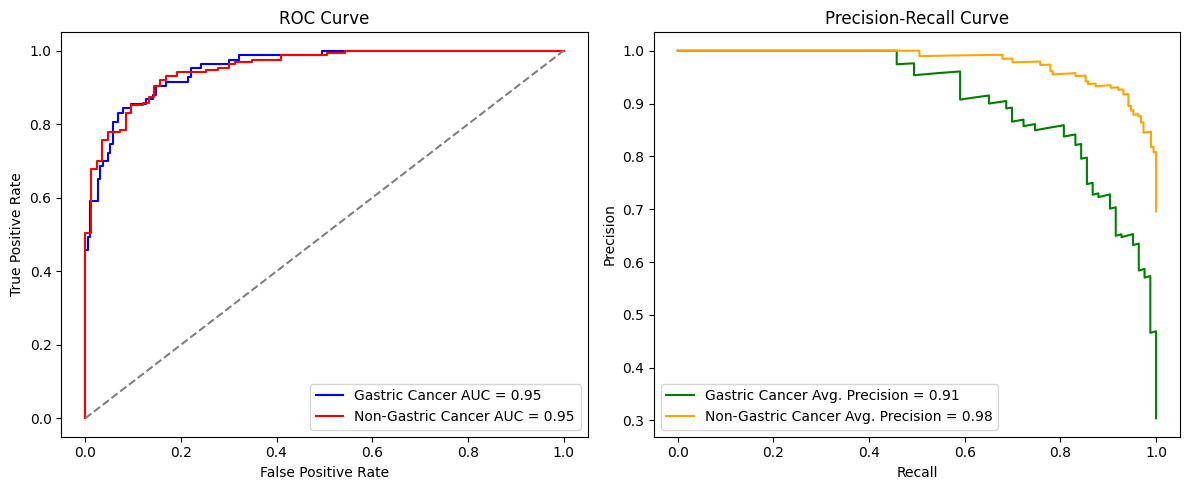

In [ ]:
# XGBoost Classifier

xgb_pipeline = Pipeline([
    ('smote', SMOTENC(categorical_features=categorical_indices_subset, random_state=26)),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        tree_method='hist',
        enable_categorical=True,
        eval_metric='logloss',
        random_state=26
    ))
])


xgb_search_space = {                      # The hyperparameter search space
    'classifier__n_estimators': Integer(50, 1000),
    'classifier__max_depth': Integer(3, 7),
    'classifier__learning_rate': Real(0.01, 0.1),
    'classifier__subsample': Real(0.5, 1),  # for bagging
    'classifier__colsample_bytree': Real(0.5, 1),  # for feature sampling
    'classifier__min_child_weight': Integer(1, 10),  # minimum sum of instance weight needed in a child
    'classifier__gamma': Real(0, 5),  # minimum loss reduction required to make a split
    'classifier__reg_alpha': Real(1e-9, 10.0, prior='log-uniform') # L1 regularization
}


xgb_bayes_search = BayesSearchCV(      # Bayesian optimization using scikit-optimize
    estimator=xgb_pipeline,
    search_spaces=xgb_search_space,
    scoring='recall',
    cv=ss,
    n_iter=30,
    n_points=2,
    n_jobs=2,
    verbose=2,
    random_state=26
)


xgb_bayes_search.fit(X_train_reduced, y_train_set_encoded) # Fit the XGBClassifier model on the reduced training set


y_test_pred = xgb_bayes_search.predict(X_test_reduced) # Get predictions on the test set

xgb_report_dict = classification_report(            # Generate the classification report as a dictionary
    le.inverse_transform(y_test_set_encoded),
    le.inverse_transform(y_test_pred),
    output_dict=True
)


xgb_report_df = pd.DataFrame(xgb_report_dict).transpose() # Convert to DataFrame
 
xgb_report_df.to_csv("../results/2025-07-12_before_calib_XGB_classification_report.csv", index=True) # Save to CSV



xgb_calibrated_model = CalibratedClassifierCV(xgb_bayes_search.best_estimator_, method='sigmoid', cv=ss) # Calibrating the model using the best estimator from Bayesian optimization
xgb_calibrated_model.fit(X_train_reduced, y_train_set_encoded)

# Get predictions
xgb_y_test_pred_calibrated = xgb_calibrated_model.predict(X_test_reduced)

# Generate the classification report as a dictionary
xgb_report_dict_calibrated = classification_report(
    le.inverse_transform(y_test_set_encoded),
    le.inverse_transform(xgb_y_test_pred_calibrated),
    output_dict=True
)

# Convert to DataFrame
xgb_report_df_calibrated = pd.DataFrame(xgb_report_dict_calibrated).transpose()

# Save to CSV
xgb_report_df_calibrated.to_csv("../results/2025-07-12_XGB_after_calibration_classification_report.csv", index=True)

y_proba_test_0 = xgb_calibrated_model.predict_proba(X_test_reduced)[:, 0] # Gastric Cancer
y_proba_test_1 = xgb_calibrated_model.predict_proba(X_test_reduced)[:, 1] # Non-Gastric Cancer
# ROC Curve
fpr_0, tpr_0, _ = roc_curve(y_test_set_encoded, y_proba_test_0, pos_label=0)
fpr_1, tpr_1, _ = roc_curve(y_test_set_encoded, y_proba_test_1, pos_label=1)

roc_auc_0 = auc(fpr_0, tpr_0)
roc_auc_1 = auc(fpr_1, tpr_1)
# PR Curve
precision_0, recall_0, _ = precision_recall_curve(y_test_set_encoded, y_proba_test_0, pos_label=0)
pr_auc_0 = average_precision_score(y_test_set_encoded, y_proba_test_0, pos_label=0, average='weighted')

precision_1, recall_1, _ = precision_recall_curve(y_test_set_encoded, y_proba_test_1, pos_label=1)
pr_auc_1 = average_precision_score(y_test_set_encoded, y_proba_test_1, pos_label=1, average='weighted')
# Plotting
plt.figure(figsize=(12, 5))

# ROC Plot
plt.subplot(1, 2, 1)
plt.plot(fpr_0, tpr_0, color='blue', label=f"Gastric Cancer AUC = {roc_auc_0:.2f}")
plt.plot(fpr_1, tpr_1, color='red', label=f"Non-Gastric Cancer AUC = {roc_auc_1:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# PR Plot
plt.subplot(1, 2, 2)
plt.plot(recall_0, precision_0, color='green', label=f"Gastric Cancer Avg. Precision = {pr_auc_0:.2f}")
plt.plot(recall_1, precision_1, color='orange', label=f"Non-Gastric Cancer Avg. Precision = {pr_auc_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.savefig("../results/2025-07-12_XGB_after_calibration_ROC_PR_curves.png", dpi=1200)
plt.show()

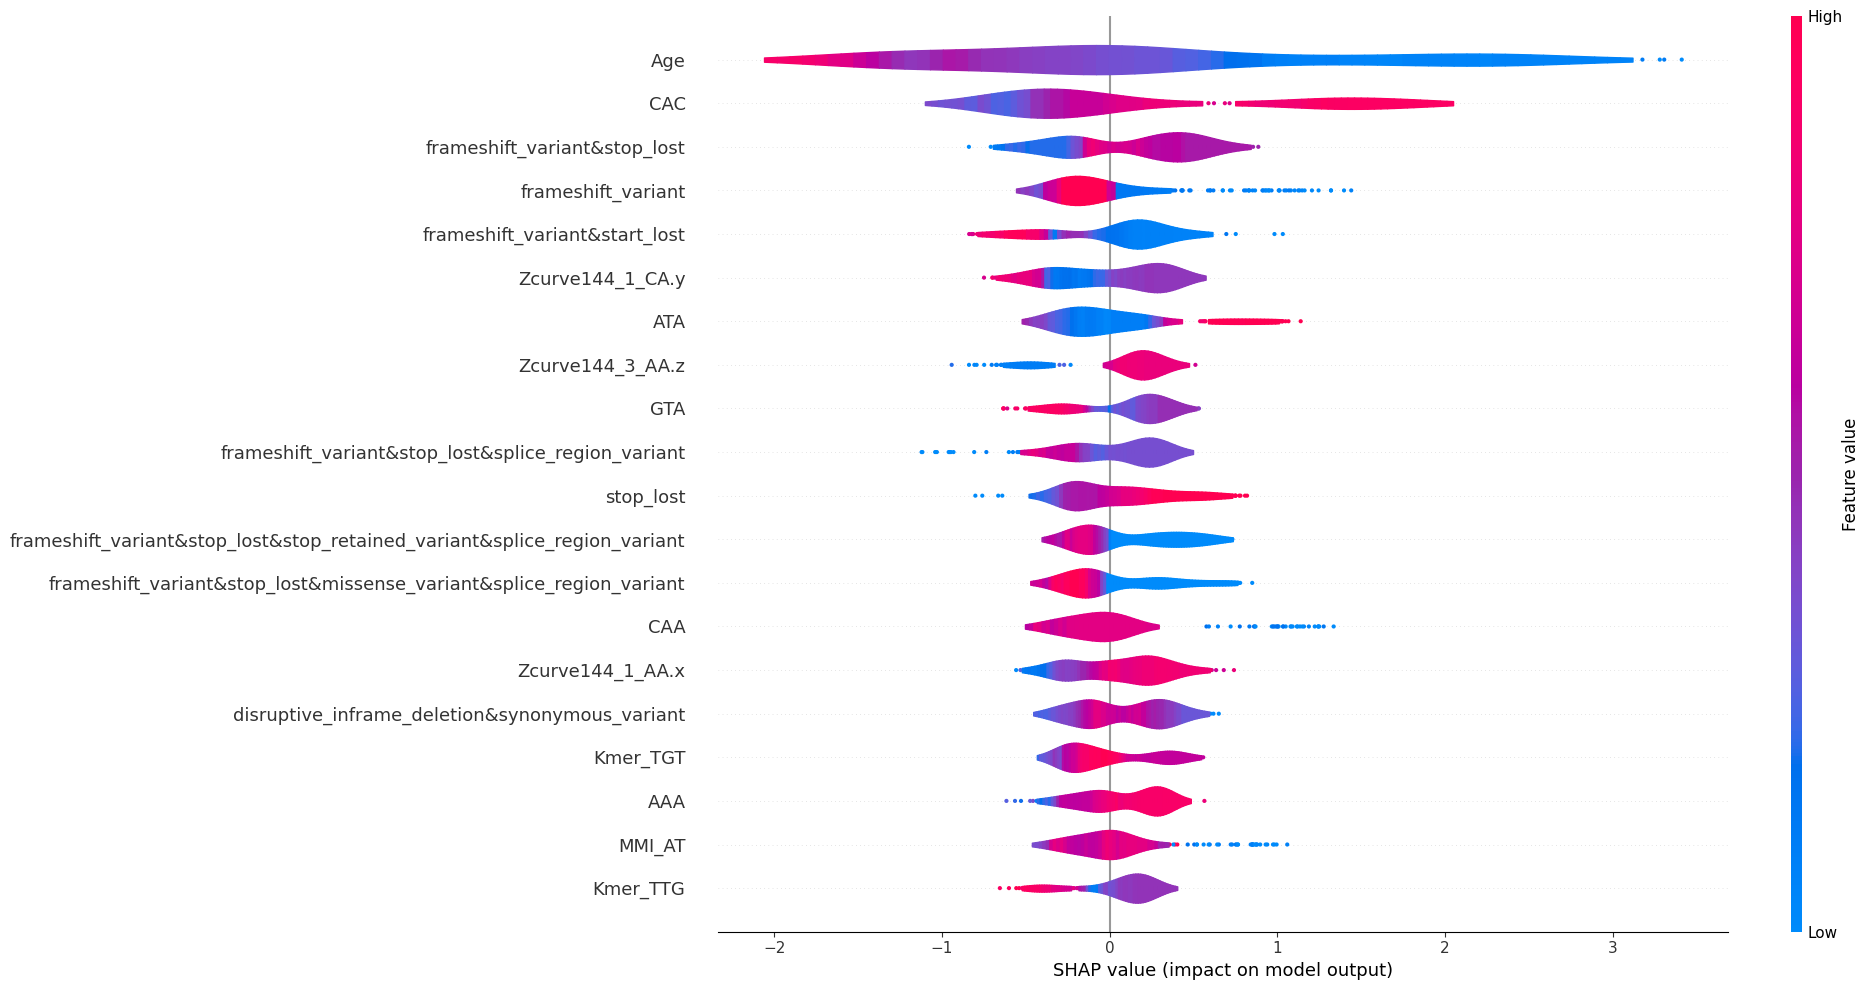

In [12]:
# SHAP global explanation
explainer = shap.TreeExplainer(xgb_calibrated_model.estimator.named_steps['classifier']) # Create SHAP explainer for the XGBoost model
shap_values = explainer.shap_values(X_test_reduced) # Compute SHAP values for the test set
shap.summary_plot(shap_values, X_test_reduced, plot_size=(20, 10), plot_type="violin", show=False)
plt.savefig("../results/2025-07-07_XGB_shap_summary_plot.png", dpi=1200, bbox_inches='tight')

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] END classifier_rf__bootstrap=False, classifier_rf__ccp_alpha=0.008916481566215747, classifier_rf__criterion=gini, classifier_rf__max_depth=5, classifier_rf__min_samples_leaf=6, classifier_rf__min_samples_split=10, classifier_rf__n_estimators=1075; total time=  10.1s
[CV] END classifier_rf__bootstrap=False, classifier_rf__ccp_alpha=0.008916481566215747, classifier_rf__criterion=gini, classifier_rf__max_depth=5, classifier_rf__min_samples_leaf=6, classifier_rf__min_samples_split=10, classifier_rf__n_estimators=1075; total time=  10.2s
[CV] END classifier_rf__bootstrap=False, classifier_rf__ccp_alpha=0.008916481566215747, classifier_rf__criterion=gini, classifier_rf__max_depth=5, classifier_rf__min_samples_leaf=6, classifier_rf__min_samples_split=10, classifier_rf__n_estimators=1075; total time=   8.4s
[CV] END classifier_rf__bootstrap=False, classifier_rf__ccp_alpha=0.008916481566215747, classifier_rf__criterion=gini, clas

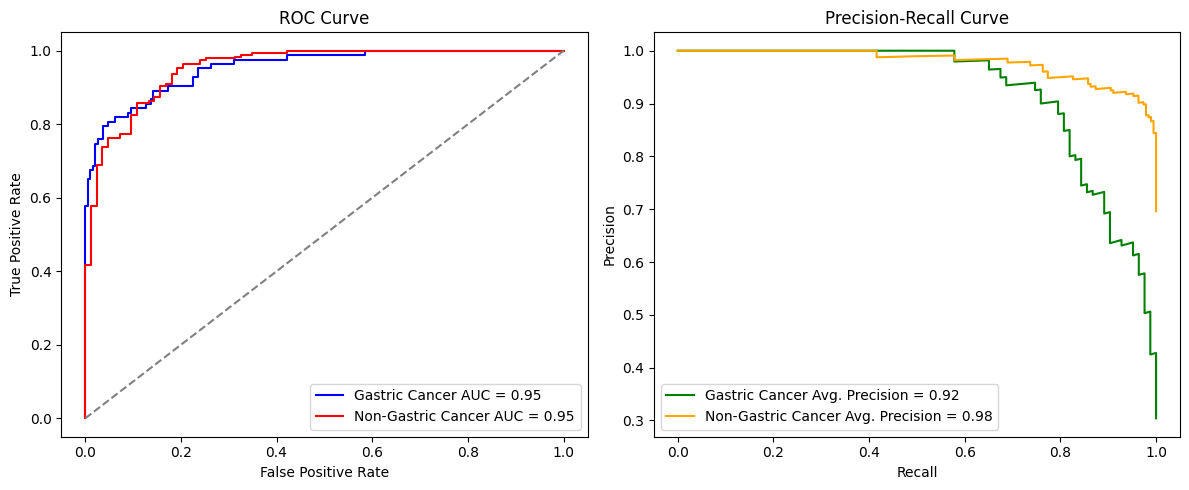

Exception ignored in: <function ResourceTracker.__del__ at 0x7390df8384a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f9da692c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

In [ ]:
# Random Forest Classifier

# Create the pipeline
rf_pipeline = Pipeline([('smotenc', SMOTENC(categorical_features=categorical_indices_subset, random_state=26)),
    ('classifier_rf', RandomForestClassifier(random_state=26))
])

params_rf_bayes = {
    'classifier_rf__n_estimators': Integer(50, 2000),
    'classifier_rf__criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'classifier_rf__max_depth': Integer(3, 10),
    'classifier_rf__min_samples_split': Integer(2, 10),
    'classifier_rf__min_samples_leaf': Integer(1, 10),
    'classifier_rf__bootstrap': Categorical([True, False]),
    'classifier_rf__ccp_alpha': Real(1e-6, 0.01, prior='log-uniform'),
}

bayes_search_rf = BayesSearchCV(
    estimator=rf_pipeline,
    search_spaces=params_rf_bayes,
    scoring='recall',
    cv=ss,
    n_iter=30,
    n_points=2,
    n_jobs=2,
    verbose=2,
    random_state=26
)
# Fit the model
bayes_search_rf.fit(X_train_reduced, y_train_set_encoded)

# Get predictions
y_test_pred_rf = bayes_search_rf.predict(X_test_reduced)

# Generate the classification report as a dictionary
report_dict_rf = classification_report(
    le.inverse_transform(y_test_set_encoded),
    le.inverse_transform(y_test_pred_rf),
    output_dict=True
)

# Convert to DataFrame
report_df_rf = pd.DataFrame(report_dict_rf).transpose()

# Save to CSV
report_df_rf.to_csv("../results/2025-07-07_RF_before_calibration_classification_report.csv", index=True)


rf_calibrated_model = CalibratedClassifierCV(bayes_search_rf.best_estimator_, method='sigmoid', cv=ss)
rf_calibrated_model.fit(X_train_reduced, y_train_set_encoded)

# Get predictions
rf_y_test_pred_calibrated = rf_calibrated_model.predict(X_test_reduced)

# Generate the classification report as a dictionary
rf_report_dict_calibrated = classification_report(
    le.inverse_transform(y_test_set_encoded),
    le.inverse_transform(rf_y_test_pred_calibrated),
    output_dict=True
)

# Convert to DataFrame
rf_report_df_calibrated = pd.DataFrame(rf_report_dict_calibrated).transpose()

# Save to CSV
rf_report_df_calibrated.to_csv("../results/2025-07-07_RF_after_calibration_classification_report.csv", index=True)

y_proba_test_0 = rf_calibrated_model.predict_proba(X_test_reduced)[:, 0] # Gastric Cancer
y_proba_test_1 = rf_calibrated_model.predict_proba(X_test_reduced)[:, 1] # Non-Gastric Cancer
# ROC Curve
fpr_0, tpr_0, _ = roc_curve(y_test_set_encoded, y_proba_test_0, pos_label=0)
fpr_1, tpr_1, _ = roc_curve(y_test_set_encoded, y_proba_test_1, pos_label=1)

roc_auc_0 = auc(fpr_0, tpr_0)
roc_auc_1 = auc(fpr_1, tpr_1)
# PR Curve
precision_0, recall_0, _ = precision_recall_curve(y_test_set_encoded, y_proba_test_0, pos_label=0)
pr_auc_0 = average_precision_score(y_test_set_encoded, y_proba_test_0, pos_label=0, average='weighted')

precision_1, recall_1, _ = precision_recall_curve(y_test_set_encoded, y_proba_test_1, pos_label=1)
pr_auc_1 = average_precision_score(y_test_set_encoded, y_proba_test_1, pos_label=1, average='weighted')
# Plotting
plt.figure(figsize=(12, 5))

# ROC Plot
plt.subplot(1, 2, 1)
plt.plot(fpr_0, tpr_0, color='blue', label=f"Gastric Cancer AUC = {roc_auc_0:.2f}")
plt.plot(fpr_1, tpr_1, color='red', label=f"Non-Gastric Cancer AUC = {roc_auc_1:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# PR Plot
plt.subplot(1, 2, 2)
plt.plot(recall_0, precision_0, color='green', label=f"Gastric Cancer Avg. Precision = {pr_auc_0:.2f}")
plt.plot(recall_1, precision_1, color='orange', label=f"Non-Gastric Cancer Avg. Precision = {pr_auc_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.savefig("../results/2025-07-12_RF_after_calibration_ROC_PR_curves.png", dpi=1200)
plt.show()

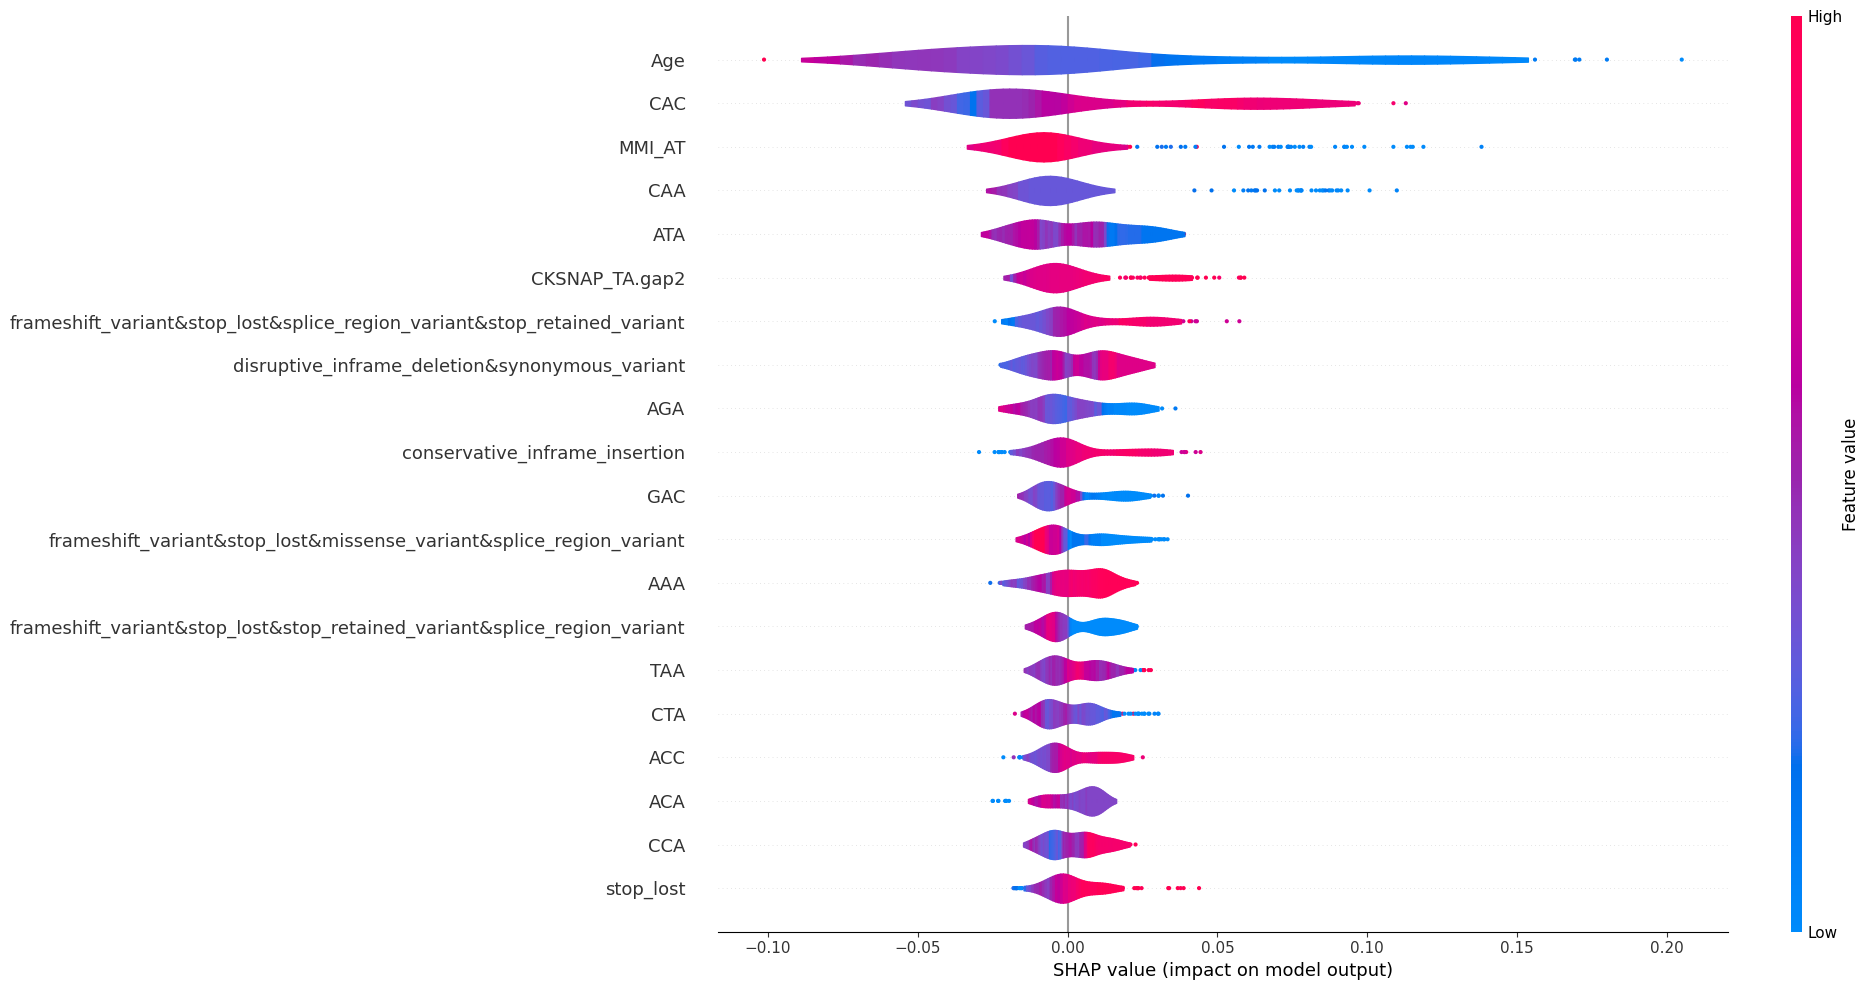

In [14]:
rf_explainer = shap.TreeExplainer(rf_calibrated_model.estimator.named_steps['classifier_rf']) # Create SHAP explainer for the Random Forest model
rf_shap_values = rf_explainer.shap_values(X_test_reduced)
shap.summary_plot(rf_shap_values[:,:,1], X_test_reduced, plot_size=(20, 10), plot_type="violin", show=False)
plt.savefig("../results/2025-07-12_RF_after_calibration_shap_summary_plot.png", dpi=1200)

In [17]:
# DeLong's test for comparing AUCs
from MLstatkit.stats import Delong_test

true = y_test_set_encoded
prob_A = xgb_calibrated_model.predict_proba(X_test_reduced)[:, 0] # Gastric Cancer
prob_B = lr_pipeline.predict_proba(X_test_set_encoded)[:, 0] # Gastric Cancer

# DeLong's test
z_score, p_value = Delong_test(true, prob_A, prob_B)
print(f"Z-score: {z_score}, P-value: {p_value}")

Z-score: -3.1352559060615994, P-value: 0.0017170425543178239


In [21]:
# DeLong's test for comparing AUCs
from MLstatkit.stats import Delong_test

true = y_test_set_encoded
prob_A = rf_calibrated_model.predict_proba(X_test_reduced)[:, 0] # Gastric Cancer
prob_B = lr_pipeline.predict_proba(X_test_set_encoded)[:, 0] # Gastric Cancer

# DeLong's test
z_score, p_value = Delong_test(true, prob_A, prob_B)
print(f"Z-score: {z_score}, P-value: {p_value}")

Z-score: -3.2085019288115304, P-value: 0.001334284142251791
